# Resumen
En este notebook vamos a partir del fichero original de airbnb (airbnb-listings.csv).

Llevaremos a cabo la misma limpieza y seleccion de caracteristicas que hicimos en el caso de la practica del mudulo de Machine Learning. 

A esos datos una vez limpios y processados (Normalizacion, correlacion, outliers, categorizacion) le aplicaremos una red Neuronal tradicional para ver la bondad de ese modelo.

# Montar directorio Drive en colab
En primer lugar vamos a montar el directorio de Drive para poder utilizar los ficheros de carga y para guardar de manera permanente otros ficheros de interes

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
from os.path import join
ROOT = "/content/gdrive"
PROJ = "My Drive/Public/Practica_Deep_Learning_DA" 
PROJECT_PATH = join(ROOT, PROJ)

In [0]:
!ls "/content/gdrive/My Drive/Public/Practica_Deep_Learning_DA"

'Copia de regresion_Keras.ipynb'   nn_regresion_01.ipynb
 data				   nn_regresion_02.ipynb
 descarga_imagenes.ipyn		   practica_dl.ipynb
 descarga_imagenes_OLD.old	   README.md
 Explicacion_Practica.ipynb	   util
 images


# Librerías y funciones

Lo primero es cargar las librerías y funciones necesarias.

In [0]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
%matplotlib inline

cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF0000', '#0000FF'])

import warnings
warnings.filterwarnings('ignore')

#Para incluir en Colab las funciones del package utilidades creado por mi
from importlib.machinery import SourceFileLoader
import sys

missing_values_table = SourceFileLoader('missing_values_table', join(PROJECT_PATH, 'util/utilidades.py')).load_module()
change_cat_to_other = SourceFileLoader('change_cat_to_other', join(PROJECT_PATH, 'util/utilidades.py')).load_module()

sys.path.append('/content/gdrive/My\ Drive/Public/Practica_Deep_Learning_DA/util')
from missing_values_table import missing_values_table
from change_cat_to_other import change_cat_to_other


# Analisis exploratorio

## Datos de entrada

Cargamos los datos del fichero de airbnb reducido.
Este fichero contiene 14870 observaciones y 89 variables

In [0]:
full_airbnb = pd.read_csv(join(PROJECT_PATH,'data/airbnb-listings.csv'),sep=';', decimal='.')

## Outliers
Antes de nada, vamos a hacer una pequeña limpieza de los outliers de precio,

In [0]:
full_airbnb = full_airbnb[(full_airbnb['Price']>10) & (full_airbnb['Price']<200)]

## Limpieza general

In [0]:
missing_values_table(full_airbnb)

Your slelected dataframe has 89 columns.
There are 58 columns that have missing values.


,Missing Values,% of Total Values
Has Availability,14049,99.92
Host Acceptance Rate,14027,99.77
Jurisdiction Names,13858,98.56
License,13734,97.68
Square Feet,13487,95.92
Monthly Price,10603,75.41
Weekly Price,10490,74.61
Notes,8676,61.71
Security Deposit,8091,57.55
Interaction,6100,43.39


Antes de llevar a cabo el split entre Trainintg y Test eliminamos las columnas que tenemos claro que no van a ser utiles para nuestro objetivo:
1. **Las que contienen URLs**: Listing Url: drop_url  
2. **Los Ids y lo relativo al Scrape realizado**: drop_id_scrape
3. **Nombres y comentarios**:drop_comments
4. **Direcciones**: A la vista de la informacion que contienen las variables de direccion podemos dropear varias de ellas por diversos motivos (sin que tengamos que dividir previamente en Train Test). Demasiado genericas: City, State, Market, Smart Location, Country Code, Country, Jurisdiction Names. Demasiado concretas: Street, Latitude, Longitude y Geolocation. Demasiado ruido o demasiados registros nulos: Neighbourhood, Host Location, Host Neighbourhood. Por ultimo, Zipcode es una variable que para representar la direccion no me parece la mas adecuada debido a que aunque es un numero, deberia ser tratado como una variable categorica. Ademas contiene bastante ruido, una cantidad no despreciable de nulos y tambien es demasiado concreta (506 valores unicos)     Por tanto y para la evaluacion del modelo deberemos barajar cual de las dos opciones que quedan es la mejor para representar la "zona" en la que se encuentra el piso ( Neighbourhood Cleansed o Neighbourhood Group Cleansed, las cuales obviamente van a estar fuertemente correladas), pero esto debera hacerse una vez separado el dataset, para que los datos de Test no influyan en la decision. (En cualquier caso sera necesario hacer un trabajo de limpieza y categorizacion con la variable elegida):drop_address
5. **Informascion relativa al Hospedador**: drop_host

In [0]:
drop_url = np.array(['Listing Url', 'Thumbnail Url', 'Medium Url', 'Picture Url', 'XL Picture Url', 'Host URL',
                     'Host Thumbnail Url','Host Picture Url'])
full_airbnb.drop(drop_url, axis=1, inplace=True)

drop_id_scrape = np.array(['ID', 'Scrape ID', 'Last Scraped', 'Host ID', 'Calendar last Scraped'])
full_airbnb.drop(drop_id_scrape, axis=1, inplace=True)


drop_comments = np.array(['Name', 'Summary', 'Space', 'Description', 'Neighborhood Overview', 'Notes',
                     'Transit','Access', 'Interaction', 'House Rules', 'Host Name', 'Experiences Offered',
                         'Host About', 'Amenities', 'Features'])

full_airbnb.drop(drop_comments, axis=1, inplace=True)

drop_address = np.array(['Host Location', 'Host Neighbourhood', 'Neighbourhood', 'Street', 'Zipcode', 
    'City', 'State', 'Market', 'Smart Location','Country Code', 'Country', 'Latitude', 
                         'Longitude', 'Jurisdiction Names', 'Geolocation'])

full_airbnb.drop(drop_address, axis=1, inplace=True)

drop_host = np.array(['Host Since', 'Host Response Time', 'Host Response Rate', 'Host Acceptance Rate', 
    'Host Listings Count', 'Host Total Listings Count','Host Verifications', 'Calculated host listings count'])

full_airbnb.drop(drop_host, axis=1, inplace=True)



Por ultimo eliminamos varios campos sueltos por los siguientes motivos:
* **Square Feet**: Contiene 96% observaciones null
* **Weekly Price**: Contiene 76% observaciones null
* **Monthly Price**: Contiene 76% obsevaciones null
* **Has Availability**: Contiene 99% observaciones null
* **First Review**: No creemos que aporte informacion util para el calculo del precio
* **Last Review**: No creemos que aporte informacion util para el calculo del precio
* **Calendar Updated**: No creemos que aporte informacion util para el calculo del precio
* **License**: Contiene 98% observaciones null
* **Bed Type**: Casi el 99% de las camas son del mismo tipo (Real Bed)




In [0]:
drop_varios = np.array(['Square Feet', 'Weekly Price', 'Monthly Price', 'Has Availability', 'First Review', 'Last Review',
                     'Calendar Updated','License', 'Bed Type'])

full_airbnb.drop(drop_varios, axis=1, inplace=True)


**Tras la limpeza inicial nos hemos quedado con 29 caracteristicas (y el target).**

## Separación Train Test

Ahora, y antes de pasar al analisis exploratorio y la seleccion de caratresiticas procemos a la divsion del dataset de entrada en train y test. De momento y por si llevamos a cabo tratamiento de outliers no separaremos la variable objetivo del resto de caracteristicas.

In [0]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(full_airbnb, test_size=0.2, shuffle=True, random_state=0)
print(f'Dimensiones del dataset de training: {train.shape}')
print(f'Dimensiones del dataset de test: {test.shape}')
# Guardamos
train.to_csv('/content/gdrive/My Drive/Public/Practica_Deep_Learning_DA/data/train.csv', sep=';', decimal='.', index=False)
test.to_csv('/content/gdrive/My Drive/Public/Practica_Deep_Learning_DA/data/test.csv', sep=';', decimal='.', index=False)

Dimensiones del dataset de training: (11248, 29)
Dimensiones del dataset de test: (2812, 29)


**Tengamos en cuenta que a partir de ahora todo el analisis exploratorio y selección de caracteristicas se hara sobre el dataset de entrenamiento.**
**Posteriormente todas transformaciones llevadas a cabo en dicho dataset se deberan implementar en el de Test.**

## Limpieza y preprocesado de variables categoticas

Empecemos tratando las variables de vecindario (Neighbourhood Cleansed y Neighbourhood Group Cleansed)

In [0]:
print(len(train['Neighbourhood Cleansed'].unique()))
print(train['Neighbourhood Cleansed'].isna().sum())
with pd.option_context("display.max_rows", 1000):
    print(train['Neighbourhood Cleansed'].value_counts())

In [0]:
print(len(train['Neighbourhood Group Cleansed'].unique()))
print(train['Neighbourhood Group Cleansed'].isna().sum())
with pd.option_context("display.max_rows", 1000):
    print(train['Neighbourhood Group Cleansed'].value_counts())

A la vista de los datos anteriores tenemos la siguiente informacio:
- La variable "Neighbourhood Cleansed" contiene 449 categorias y ningun valor null.
- La variable "Neighbourhood Group Cleansed contiene 49 categorias y 819 celdas null.En lugar de imputar los nulls a la categoria "Other" lo rellenamos con el valor de la columna "Neighbourhood Cleansed"

In [0]:
train['Neighbourhood Group Cleansed'].fillna(train['Neighbourhood Cleansed'], inplace=True)

Es cierto que ahora hemos pasado de 49 categorias a 277, pero creemos que esta distribucion es mas realista que la de incluir tantos pisos en la categoria de Other.



A continuación trataremos las otras tres variables categoricas que nos quedan (Property Type, Room Type y Cancellation Policy)

In [0]:
print(train['Property Type'].value_counts())
print(train['Room Type'].value_counts())
print(train['Cancellation Policy'].value_counts())


Apartment             9181
House                  963
Bed & Breakfast        271
Condominium            268
Loft                   246
Other                  176
Dorm                    37
Guesthouse              32
Chalet                  18
Hostel                  12
Townhouse               12
Serviced apartment       9
Boutique hotel           5
Villa                    5
Boat                     4
Casa particular          2
Earth House              2
Camper/RV                1
Bungalow                 1
Timeshare                1
Guest suite              1
Tent                     1
Name: Property Type, dtype: int64
Entire home/apt    6750
Private room       4346
Shared room         152
Name: Room Type, dtype: int64
strict             4282
flexible           3581
moderate           3302
strict_new           23
super_strict_60      18
moderate_new         17
super_strict_30      15
flexible_new         10
Name: Cancellation Policy, dtype: int64


Vamos a dejar las categorias de Property Type en "Apartment", "House", "Condominium", "Bed & Breakfast", "Loft", "Dorm", "Guesthouse", "Chalet", "Townhouse", "Hostel" y "Villa" que representan mas del 95% del total y todas las demas las incluiremos en la categoría "Other".
Para ello usaremos la funcion change_cat_to_other del pakcage utilidades

In [0]:
array_main_cat_property_type = ['Apartment', 'House', 'Condominium', 'Bed & Breakfast', 'Loft', 'Dorm', 'Guesthouse',
                               'Chalet', 'Townhouse', 'Hostel', 'Villa']
train['Property Type'] = change_cat_to_other(array_main_cat_property_type, train['Property Type'])
train['Property Type'].value_counts()

Apartment          9181
House               963
Bed & Breakfast     271
Condominium         268
Loft                246
Other               203
Dorm                 37
Guesthouse           32
Chalet               18
Hostel               12
Townhouse            12
Villa                 5
Name: Property Type, dtype: int64

De la misma manera vamos a dejar las categorias de Cancellation Policy en "strict", "flexible" y "moderate", que representan mas del 96% del total y todas las demas las incluiremos en la categoría "Other".
Usamos nuevamente la funcion change_cat_to_other

In [0]:
array_main_cat_cancellation_policy = ['strict', 'flexible', 'moderate']
train['Cancellation Policy'] = change_cat_to_other(array_main_cat_cancellation_policy, train['Cancellation Policy'])
train['Cancellation Policy'].value_counts()

strict      4282
flexible    3581
moderate    3302
Other         83
Name: Cancellation Policy, dtype: int64

## Codificacion de las variables categoricas (Mean encoding)
Una vez reducidas las categorias de las variables categoricas, las convertiremos en numericas mediante el mecanismo de mean
encoding.
Guardamos las transformacion hechas en Train para reproducirlas en Test con un replace o un map sin volver a aplicar el mean encoding para evitar que los datos de test infulyan en el modelo.
Para aplicar le metodo Mean Encoding es conveniente que no haya NaNs en la variable Target (Price), por ello imputaremos esos valores con la media de los precios.

In [0]:
y_train_mean = np.mean(train['Price'])
train['Price'] = train['Price'].fillna(y_train_mean)

In [0]:
#Property Type
mean_encode_property_type = train.groupby('Property Type')['Price'].mean()
train.loc[:,'Property Type'] = train['Property Type'].map(mean_encode_property_type)

#Cancellation Policy 
mean_encode_cancellation_policy = train.groupby('Cancellation Policy')['Price'].mean()
train.loc[:,'Cancellation Policy'] = train['Cancellation Policy'].map(mean_encode_cancellation_policy)

#Room Type
mean_encode_room_type = train.groupby('Room Type')['Price'].mean()
train.loc[:,'Room Type'] = train['Room Type'].map(mean_encode_room_type)

#Neighbourhood Cleansed
mean_encode_neigh = train.groupby('Neighbourhood Cleansed')['Price'].mean()
train.loc[:,'Neighbourhood Cleansed'] = train['Neighbourhood Cleansed'].map(mean_encode_neigh)

#Neighbourhood Group Cleansed
mean_encode_neigh_group = train.groupby('Neighbourhood Group Cleansed')['Price'].mean()
train.loc[:,'Neighbourhood Group Cleansed'] = train['Neighbourhood Group Cleansed'].map(mean_encode_neigh_group)


## Correlacion de variables


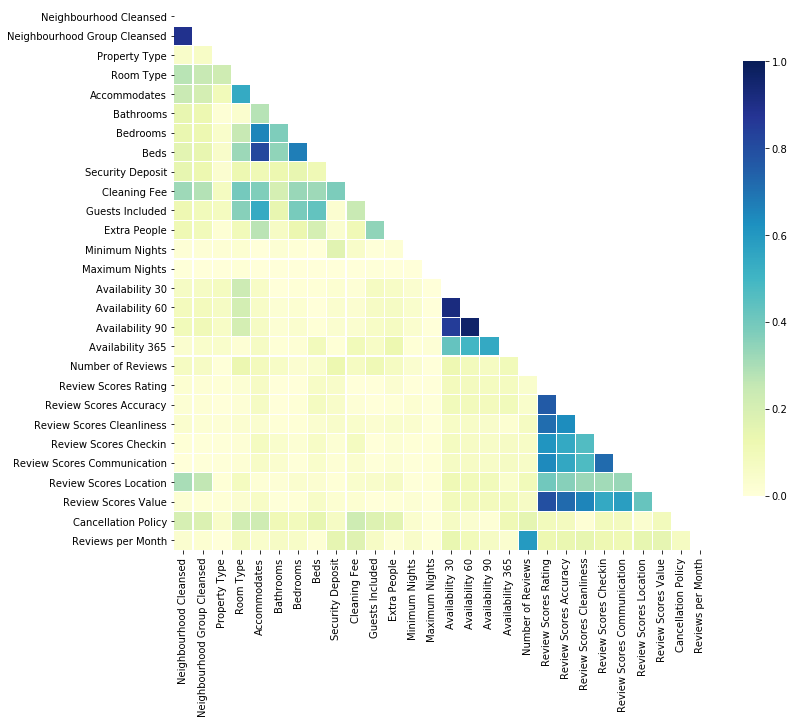

In [0]:
import seaborn as sns

# Compute the correlation matrix
corr = np.abs(train.drop(['Price'], axis=1).corr())

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(12, 10))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask,vmin = 0.0, vmax=1.0, center=0.5,
            linewidths=.1, cmap="YlGnBu", cbar_kws={"shrink": .8})

plt.show()

A la vista de la grafica de correlacion y siendo un poco generosos con las variables a eliminar para simplificar el modelo, podemos deducir lo siguiente:
1. **Accommodates** tiene una fuerte correlacion con Bedrooms, Beds y moderada con Guests Included
2. **Availability 30** tiene fuerte correlacion con Availability 60 Availability 90 y moderada con Availability 365
3. **Review Scores Rating** tiene una fuerte correlacion con Review Scores Accuracy, Review Scores Cleanliness, Review Scores Checkin, Review Scores Communication, Review Scores Value y moderada con Review Scores Location.
4. **Number of Reviews** tiene fuerte  correlacion con Reviews per Month
5. **Neighbourhood Cleansed y Neighbourhood Group Cleansed** muestran una fuerte correlacion, pero de momento dejamos las dos para analizar mediante el filtrado de caracterisdtcas cual de las dos influye mas en la regresion que tenemos que plantear.

In [0]:
#Vamos a eliminar todas estas variables del dataset de entrenamiento
drop_corr = ['Bedrooms', 'Beds', 'Guests Included', 'Availability 60', 'Availability 90', 'Availability 365',
             'Review Scores Accuracy', 'Review Scores Cleanliness', 'Review Scores Checkin', 'Review Scores Communication',
             'Review Scores Value', 'Review Scores Location', 'Reviews per Month']
train.drop(drop_corr, axis=1, inplace=True)
train.shape

(11248, 16)

## Tratamiento de NaNs (Imputacion de nulos)

Ningun modelo de Machine o Deep Learning funcionan adecuadamente sin un tratamiento previo de los NaNs de sus registros.

Por tanto debemos analizar que variables tienen valores NaN y llevemos a cabo el proceso de imputacion

Para hacerlo una opcion seria aplicar los siguientes comandos a todas las variables que quedan:
```
print(len(train['campo'].unique()))
print(train['campo'].isna().sum())
print(train['campo'].value_counts())

```

Afortunadamente contamos con la funion missing_values_table que nos permite visualizar con un unico comando los nulos que aparecen en los distintos campos del dataframe

In [0]:
missing_values_table(train)

Your slelected dataframe has 16 columns.
There are 4 columns that have missing values.


,Missing Values,% of Total Values
Security Deposit,6432,57.18
Cleaning Fee,4586,40.77
Review Scores Rating,2376,21.12
Bathrooms,41,0.36


Haciendo esto vemos que los unicos campos que contienen NaNs son:
- Bathroom (45) Imputamos la media
- Security Deposit (6798). Es mas de la mitad de los regitros por lo que lo eliminamos
- Cleaning Fee (4857). Imputamnos un cero. asumismos que quien no tiene ese dato es porque no hay gastos de limpieza.
- Review Scores Rating (2651). Imputamos la media. **En su momento consideramos que el no tener este campo relleno no era buena señal por que probamos a imputar el minimo, en lugar de la media, pero el modelo predecia peor, por lo que desestimamos nuestra hipotesis y volvimos a la media**.

In [0]:
mean_bathroom = np.mean(train['Bathrooms'])
mean_review = np.mean(train['Review Scores Rating'])
min_review = np.min(train['Review Scores Rating'])
train['Bathrooms'] = train['Bathrooms'].fillna(mean_bathroom)
train['Cleaning Fee'] = train['Cleaning Fee'].fillna(0)
train['Review Scores Rating'] = train['Review Scores Rating'].fillna(mean_review)

In [0]:
train.drop('Security Deposit', axis=1, inplace=True)

## Separacion y tratamiento de la variable dependiente (variable objetivo o target)
Separemos el dataset train entre la varible dependiente (y_train) y el resto de variables independientes (X_train)


In [0]:
y_train = train['Price']
X_train= train.drop(['Price'], axis=1)


In [0]:
X_train.shape

(11248, 14)

In [0]:
y_train.describe()

count    11248.000000
mean        62.438122
std         37.958864
min         11.000000
25%         32.000000
50%         55.000000
75%         80.000000
max        199.000000
Name: Price, dtype: float64

In [0]:
print(len(y_train.unique()))
print(y_train.isna().sum())
print(y_train.value_counts())
print(np.mean(y_train)) 

183
0
50.0     516
60.0     455
25.0     442
30.0     440
35.0     372
        ... 
184.0      1
173.0      1
174.0      1
193.0      1
171.0      1
Name: Price, Length: 183, dtype: int64
62.43812233285917


## Filtrado para regresion
Con las 14 variables que me quedan aplico los metodos de fitrado **f_regresion** y **mutual_info_regresion**

In [0]:
from sklearn.feature_selection import f_regression, mutual_info_regression
f_test, _ = f_regression(X_train, y_train)
f_test /= np.max(f_test)
mi = mutual_info_regression(X_train, y_train)
mi /= np.max(mi)

Mostremos esta informacion en forma de grafica

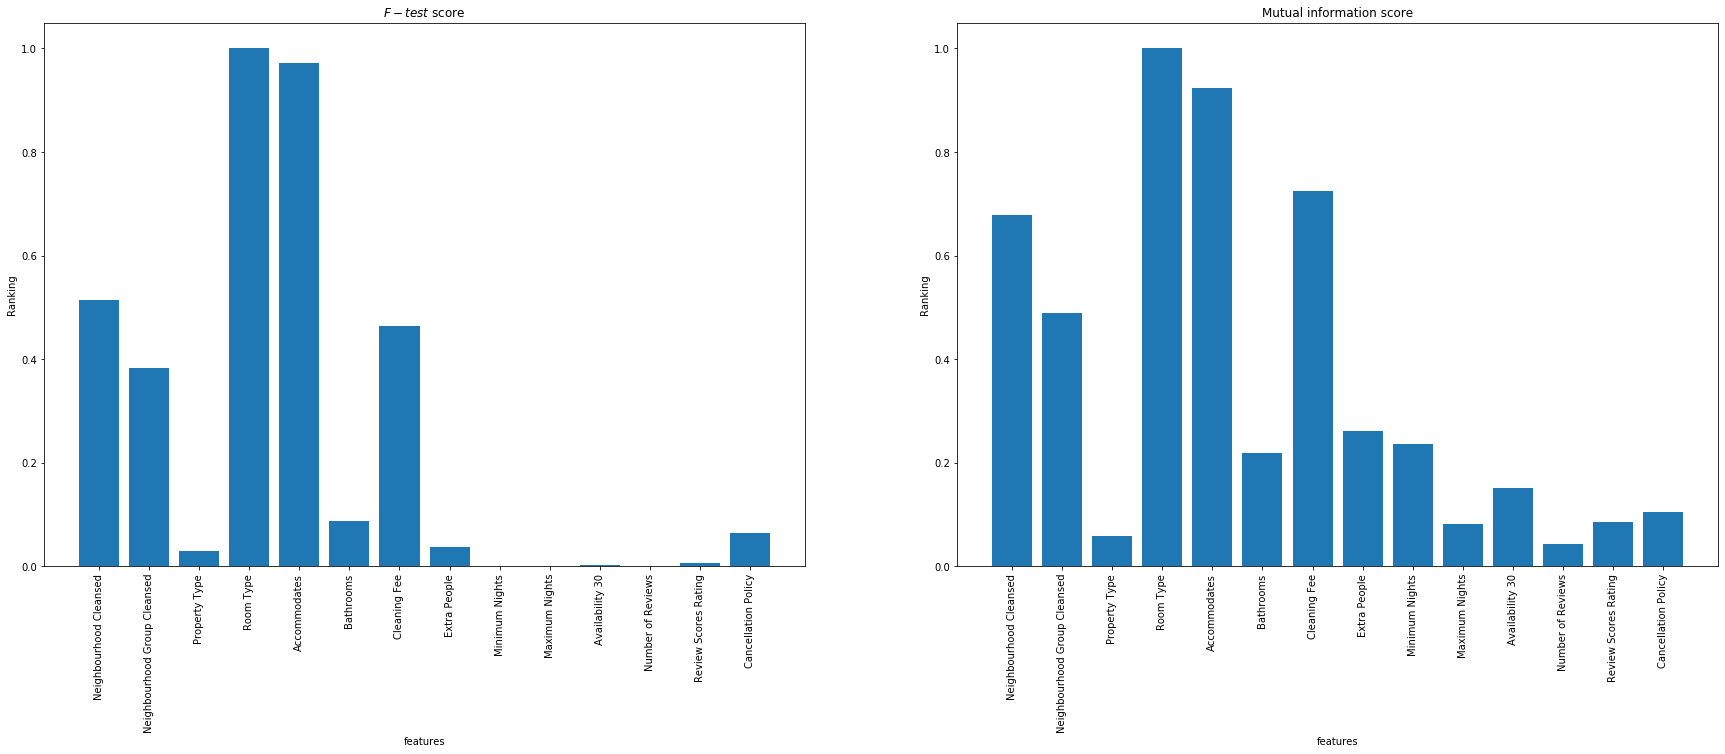

In [0]:
featureNames = list(X_train.columns)

plt.figure(figsize=(30, 10))

plt.subplot(1,2,1)
plt.bar(range(X_train.shape[1]),f_test,  align="center")
plt.xticks(range(X_train.shape[1]),featureNames, rotation = 90)
plt.xlabel('features')
plt.ylabel('Ranking')
plt.title('$F-test$ score')


plt.subplot(1,2,2)
plt.bar(range(X_train.shape[1]),mi,  align="center")
plt.xticks(range(X_train.shape[1]),featureNames, rotation = 90)
plt.xlabel('features')
plt.ylabel('Ranking')
plt.title('Mutual information score')

plt.show()

A la vista de las graficas y de los valores de f_test y mi las variables que mas estan impactando en la variable objetivo son:
- Neighbourhood Cleansed (quitamos la grupal pues como ya habiamos visto esta fuertemente correlada con esta)
- Room Type
- Accommodates
- Bathrooms
- Cleaning Fee
- Extra People
- Minimum Nigths
- Availability 30
- cancelation Policy
- Review Scores Rating

Como era de esperar el barrio, el tipo de habitacion y las personas que pueden ocupar la casa son los parametros que mas afectan al precio de la casa.

Por tanto seran estas las variables que usare para testear mis modelos, elimando el resto del dataset de training

In [0]:
drop_filtrado = ['Neighbourhood Group Cleansed', 'Property Type','Maximum Nights', 'Number of Reviews']
X_train.drop(drop_filtrado, axis=1, inplace=True)

Por ultimo cambiare el nombre de la variable "Neighbourhood Group Cleansed" por "Barrio" para que sea mas manejable

In [0]:
X_train.rename(columns={'Neighbourhood Cleansed':'Barrio'}, inplace=True)

In [0]:
X_train.describe()

,Barrio,Room Type,Accommodates,Bathrooms,Cleaning Fee,Extra People,Minimum Nights,Availability 30,Review Scores Rating,Cancellation Policy
count,11248.000000,11248.000000,11248.000000,11248.000000,11248.000000,11248.000000,11248.000000,11248.000000,11248.000000,11248.000000
mean,62.438122,62.438122,3.133535,1.227179,16.938389,7.451191,2.934655,8.663940,91.649121,62.438122
std,18.576971,23.404771,1.835781,0.541396,20.916891,10.309055,12.369022,9.092941,7.930730,7.343593
min,17.500000,28.388158,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,20.000000,53.291818
25%,51.193237,33.967326,2.000000,1.000000,0.000000,0.000000,1.000000,0.000000,90.000000,53.291818
50%,63.712644,81.535852,2.000000,1.000000,10.000000,0.000000,2.000000,6.000000,91.649121,61.493943
75%,69.968485,81.535852,4.000000,1.000000,30.000000,15.000000,3.000000,13.000000,97.000000,70.453293
max,198.000000,81.535852,16.000000,8.000000,250.000000,276.000000,1125.000000,30.000000,100.000000,81.108434


## Normalizacion
Por ultimo llevamos a cabo la normalizacion. Usaremos varias opciones para ver cual es la que mejor se adapta a nuestro modelo:
*   StandarEscaler
*   MinMax


Recordemos que para test deberemos usar el scaler obtenido en train


In [0]:
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler

#StandardScaler
standardScalerX = preprocessing.StandardScaler().fit(X_train)
XtrainStdScaled = standardScalerX.transform(X_train)

standardScalerY = preprocessing.StandardScaler().fit(np.array(y_train).reshape(-1, 1))
YtrainStdScaled = standardScalerY.transform(np.array(y_train).reshape(-1, 1))

#MinMax
cs = MinMaxScaler()
XtrainMmScaled = cs.fit_transform(X_train)

maxPrice = train["Price"].max()
YtrainMmScaled = np.array(y_train).reshape(-1, 1)/maxPrice


**Y hasta aqui el analisis exploratorio y la limpieza del dataset, empezamos con las pruebas de los modelos**

## Preparacion datos Test

Antes de iniciar la evaluacion de modelos, vamos a dejar preparado el **dataset de Test** con las mismas transformaciones que hemos llevado a cabo sobre el de Train.
Abajo indicamos el listado de dichas transformaciones para no olvidarnos de ninguna:
- Lo primero es el dropeo de las variables que no van a participar en el modelo (correlacion y filtrado): drop_corr y drop_filtrado.
- Drop de "Security Deposit"
- Tratamiento de las variables categoricas que influyen en el modelo (filtrado de categorias y Encoder): mean_encode_room_type, mean_encode_neigh y mean_encode_cancellation_policy
- Imputacion  de NaNs: Price, Bathroom y Cleaning Fee


### Analizamos y limpiamos el dataset de test

In [0]:
test = pd.read_csv('/content/gdrive/My Drive/Public/Practica_Deep_Learning_DA/data/test.csv',sep=';', decimal='.')
test.shape
#test.info()

(2812, 29)

In [0]:
missing_values_table(test)

Your slelected dataframe has 29 columns.
There are 14 columns that have missing values.


,Missing Values,% of Total Values
Security Deposit,1659,59.00
Cleaning Fee,1169,41.57
Review Scores Location,629,22.37
Review Scores Value,629,22.37
Review Scores Checkin,628,22.33
Review Scores Accuracy,625,22.23
Review Scores Cleanliness,624,22.19
Review Scores Communication,623,22.16
Review Scores Rating,618,21.98
Reviews per Month,589,20.95


In [0]:
#Dropeamos
test.drop(drop_corr, axis=1, inplace=True)
test.drop(drop_filtrado, axis=1, inplace=True)

#Eliminamos tambien la variable Security Deposit 
test.drop('Security Deposit', axis=1, inplace=True)

#imputamos los valores NaNs del target con la media del train (y_train_mean)
media_target_test = np.mean(test['Price'])
test['Price'] = test['Price'].fillna(y_train_mean)

#Imputamos los NaNs de la misma manera que se hace en Train
test['Bathrooms'] = test['Bathrooms'].fillna(mean_bathroom)
test['Cleaning Fee'] = test['Cleaning Fee'].fillna(0)
test['Review Scores Rating'] = test['Review Scores Rating'].fillna(mean_review)


#Aplicamos el Mean Encoder a "Room Type", "Neighbourhood Cleansed" y "Cancellation Policy"  el obtenido en train, si aparece alguna categoria nueva en test
#lo trataremos a posteriori
#mean_encode_room_type_test = test.groupby('Room Type')['Price'].mean()
#mean_encode_neigh_test = test.groupby('Neighbourhood Cleansed')['Price'].mean()
#mean_encode_cancellation_policy_test = test.groupby('Cancellation Policy')['Price'].mean()
test.loc[:,'Room Type'] = test['Room Type'].map(mean_encode_room_type)
test.loc[:,'Neighbourhood Cleansed'] = test['Neighbourhood Cleansed'].map(mean_encode_neigh)
test.loc[:,'Cancellation Policy'] = test['Cancellation Policy'].map(mean_encode_cancellation_policy)


#Por ultimo cambiamos el nombre de la variable a Barrio
test.rename(columns={'Neighbourhood Cleansed':'Barrio'}, inplace=True)


In [0]:
missing_values_table(test)

Your slelected dataframe has 11 columns.
There are 2 columns that have missing values.


,Missing Values,% of Total Values
Barrio,26,0.92
Cancellation Policy,22,0.78


Como quedan valores nulos en Barrio y Cancellation Policy debido a aplicar sobre ellas el Mean Encoding de train, lo rellenaremos con la media de las medias obtenidas para esas categoria

In [0]:
mean_mean_encode_neigh = np.mean(mean_encode_neigh)
mean_mean_encode_cancellation_policy = np.mean(mean_encode_cancellation_policy)
test['Barrio'].fillna(mean_mean_encode_neigh, inplace=True)
test['Cancellation Policy'].fillna(mean_mean_encode_cancellation_policy, inplace=True)


### Separamos la variable objetivo del tets

In [0]:
y_test = test['Price']
X_test= test.drop(['Price'], axis=1)

Normalizamos los datos de Test usando las normalizaciones de Train

In [0]:
#StandardScaler
XtestStdScaled = standardScalerX.transform(X_test)
YtestStdScaled = standardScalerY.transform(np.array(y_test).reshape(-1, 1))

#MinMax
cs = MinMaxScaler()
XtestMmScaled = cs.fit_transform(X_test)

YtestMmScaled = np.array(y_test).reshape(-1, 1)/maxPrice



# Red Neuronal
Creamos nuestra primera RN para una prueba de regresion
Para este ejemplo  usaremos una arquitectura sencilla de tipo Multilayer Perceptron (MLP) 

## Imports

In [0]:
# Llevamos a cabo los import necesarios

from keras.models import Sequential
from keras.layers.core import Dense
from keras.optimizers import Adam
from keras.utils import to_categorical


Using TensorFlow backend.


## Definicion del modelo de Red Neuronal

In [0]:
# Inicializamos el modelo
model = Sequential()

#Añadimos las capas neuronales tradicionales (Densas)
#Obtenemos mejores resultados (poco mejores la verdad) con selu que con relu, asi que optamos por la primera.
model.add(Dense(64,activation='selu', input_shape=(10,)))
model.add(Dense(32,activation='selu'))
model.add(Dense(8,activation='selu'))
model.add(Dense(1, activation="linear"))

#Ponemos el numero de epocas como una variable:
# veamos nuestra curva de pérdidas
#No vale la pena meterle mas de 100 eporcas porque converge pronto...
n_epochs = 100


# Compilamos el modelo
model.compile(loss='mean_absolute_error',
              optimizer=Adam(lr=0.01, decay=1e-3),
              metrics=['mae'])

## Probamos con los datos Normalizados

### Entrenamiento

In [0]:
# Entrenamos el modelo
history_callback  = model.fit(XtrainStdScaled, YtrainMmScaled,
          batch_size=64,
          shuffle=True,
          epochs=n_epochs,
          validation_data=(XtestStdScaled, YtestMmScaled))

# Evaluamos el modelo
scores = model.evaluate(XtestStdScaled, YtestMmScaled)

print('Test Loss: %.3f' % scores[0])
print('Test MAE: %.3f' % scores[1])


Train on 11248 samples, validate on 2812 samples
Epoch 1/100
11248/11248 [==============================] - 1s 77us/step - loss: 0.1627 - mean_absolute_error: 0.1627 - val_loss: 0.0929 - val_mean_absolute_error: 0.0929
Epoch 2/100
11248/11248 [==============================] - 0s 27us/step - loss: 0.0874 - mean_absolute_error: 0.0874 - val_loss: 0.0825 - val_mean_absolute_error: 0.0825
Epoch 3/100
11248/11248 [==============================] - 0s 26us/step - loss: 0.0833 - mean_absolute_error: 0.0833 - val_loss: 0.0821 - val_mean_absolute_error: 0.0821
Epoch 4/100
11248/11248 [==============================] - 0s 26us/step - loss: 0.0794 - mean_absolute_error: 0.0794 - val_loss: 0.0753 - val_mean_absolute_error: 0.0753
Epoch 5/100
11248/11248 [==============================] - 0s 28us/step - loss: 0.0783 - mean_absolute_error: 0.0783 - val_loss: 0.0776 - val_mean_absolute_error: 0.0776
Epoch 6/100
11248/11248 [==============================] - 0s 29us/step - loss: 0.0784 - mean_absolut

### Curva de perdidas

Text(0, 0.5, 'Loss')

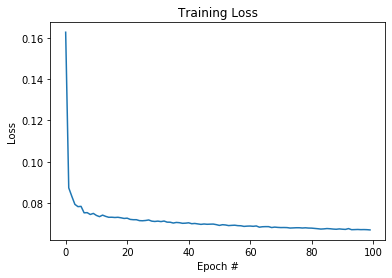

In [0]:
# veamos nuestra curva de pérdidas
plt.plot(np.arange(0, n_epochs), history_callback.history["loss"])
plt.title("Training Loss")
plt.xlabel("Epoch #")
plt.ylabel("Loss")

A la vista de estos datos observamos que el modelo converge rapidamente y a partir de la epoca 60 ya practicamente no mejora.


### Bondad del modelo.
 **Si bien el error cuadratico medio nos da una estimacion "relativa" de lo bien o mal que se comporta nuestro modelo frente a otros necesitamos un estimador diferente para hacernos una idea real de la bondad del modelo propuesto.** 

**No es lo mismo tener un mse de 300 cuando estamos prediciendo el precio de "cosas" que tienen un valor medio de 1.000 € que si obtenemos ese mismo mse para "cosas" con un precio medio de 100 €**

In [0]:
# Obtenemos la prediccion de nuestro modelo para los datos de Test
preds = model.predict(XtestStdScaled)
 

# Calulamos la diferencia entre los precios predichos y los reales
# A continuacion calcularemos la diferencia porcentual y la diferecia absouta en porcentaje
diff = preds.flatten() - YtestMmScaled
percentDiff = (diff / YtestMmScaled) * 100
absPercentDiff = np.abs(percentDiff)
 

#Calculamos la media y la desviacion estandar
mean = np.mean(absPercentDiff)
std = np.std(absPercentDiff)
 
# Mostramos las estadisticas de nuestro modelo.
print("Precio medio de las pisos: {:.2f}€, Desviacion standar: {:.2f}€".format(
    full_airbnb["Price"].mean(), full_airbnb["Price"].std()))
print("Modelo --> mean: {:.2f}%, std: {:.2f}%".format(mean, std))

Precio medio de las pisos: 62.07€, Desviacion standar: 37.64€
Modelo --> mean: 83.73%, std: 105.87%


## Probamos ahora sin Normalizar

**¡¡¡¡¡IMPORTANTE!!!! Debemos volver a ejecutar la celda en la que se crea la Red Neuronal para resetearla antes de volver a entrenarla con los datos sin normalizar**

**No he sido capaz de entensder porque obtengo mejores resultados (mejor bondad del modelo) con los datos sin normalizar que normalizados.**

### Entrenamiento

In [0]:
# Entrenamos el modelo
history_callback  = model.fit(X_train, y_train,
          batch_size=64,
          shuffle=True,
          epochs=n_epochs,
          validation_data=(X_test, y_test))

# Evaluamos el modelo
scores = model.evaluate(X_test, y_test)

print('Test Loss: %.3f' % scores[0])
print('Test MSE: %.3f' % scores[1])


Train on 11248 samples, validate on 2812 samples
Epoch 1/100
11248/11248 [==============================] - 1s 67us/step - loss: 18.1455 - mean_absolute_error: 18.1455 - val_loss: 16.8078 - val_mean_absolute_error: 16.8078
Epoch 2/100
11248/11248 [==============================] - 0s 29us/step - loss: 16.7401 - mean_absolute_error: 16.7401 - val_loss: 16.1794 - val_mean_absolute_error: 16.1794
Epoch 3/100
11248/11248 [==============================] - 0s 28us/step - loss: 16.0868 - mean_absolute_error: 16.0868 - val_loss: 15.5543 - val_mean_absolute_error: 15.5543
Epoch 4/100
11248/11248 [==============================] - 0s 28us/step - loss: 16.0361 - mean_absolute_error: 16.0361 - val_loss: 15.2980 - val_mean_absolute_error: 15.2980
Epoch 5/100
11248/11248 [==============================] - 0s 28us/step - loss: 15.5327 - mean_absolute_error: 15.5327 - val_loss: 16.5048 - val_mean_absolute_error: 16.5048
Epoch 6/100
11248/11248 [==============================] - 0s 26us/step - loss: 1

### Curva de perdidas

Text(0, 0.5, 'Loss')

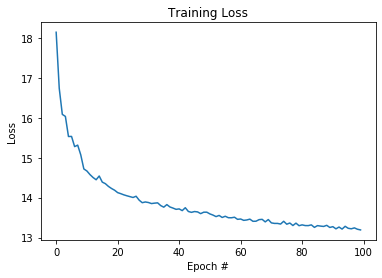

In [0]:
# veamos nuestra curva de pérdidas
plt.plot(np.arange(0, n_epochs), history_callback.history["loss"])
plt.title("Training Loss")
plt.xlabel("Epoch #")
plt.ylabel("Loss")

A la vista de estos datos observamos una curva con muchas mas irregularidades y que tarda mas en converger.


### Bondad del modelo

In [0]:
# Obtenemos la prediccion de nuestro modelo para los datos de Test
preds = model.predict(X_test)
 

# Calulamos la diferencia entre los precios predichos y los reales
# A continuacion calcularemos la diferencia porcentual y la diferecia absouta en porcentaje
diff = preds.flatten() - y_test
percentDiff = (diff / y_test) * 100
absPercentDiff = np.abs(percentDiff)
 

#Calculamos la media y la desviacion estandar
mean = np.mean(absPercentDiff)
std = np.std(absPercentDiff)
 
# Mostramos las estadisticas de nuestro modelo.
print("Precio medio de las pisos: {:.2f}€, Desviacion standar: {:.2f}€".format(
    full_airbnb["Price"].mean(), full_airbnb["Price"].std()))
print("Modelo --> mean: {:.2f}%, std: {:.2f}%".format(mean, std))

Precio medio de las pisos: 62.07€, Desviacion standar: 37.64€
Modelo --> mean: 25.16%, std: 26.73%


In [0]:
history_callback.history["loss"]